# Analysis of PageRank Algorithm on PPI network
I created a PPI network using the interactions from ConsensusPathDB and I joined it with gene expression data (dual RNA-seq) obtained for the legionella infection setting.

In the dual RNA-seq, we have the following groups:
* *Control* (not treated)
* *GFP+* (cells with legionella infection)
* *GFP-* (cells without legionella)
* *PAM3* (inflammatory substance treatment. Should produce results similar to GFP+)

The gene expression for ~40.000 genes was preprocessing in the following way:
* Kick out genes whose average gene expression was higher than $10 \times$ the standard deviation
* Kick out genes with only less than 50% of the gene expressions being different from 0
* Scaled using a standard scaler

The network was then constructed for those genes only. That is, an edge is drawn between two genes only if both of them are in the list of genes for which we have gene expression and if the confidence of the interactions exceed $0.5$.

On this network I applied the well-known PageRank algorithm. This resulted in a score for each gene and a higher score means that the gene is more important in the network.

**The goal of this notebook is to evaluate the results from PageRank, look into correlations with gene expression/differential expression, pathways and finally visualize the important genes in the network.**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Load PageRank scores & Indices
This loads the gene expression data as well as the raw network from our hdf5 container.

In [40]:
# load gene expression values and network
fname = '../preprocessing/ppi_networks.h5'
with h5py.File(fname, 'r') as f:
    gene_expression_data = pd.DataFrame(f['gene_expression'][:])
    ppi_network = f['consensusPathDB_ppi'][:]
    gene_names = f['gene_names'][:]

# load pagerank scores and ranks
pagerank_scores = pd.DataFrame.from_csv('../pagerank/pagerank_scores.txt',
                                        encoding='utf-8',
                                        sep='\t',
                                        index_col=0
                                       )
pagerank_scores

,Gene_Name,Rank,PageRank_Score
Gene_ID,,,
ENSG00000198400,NTRK1,1,0.003601
ENSG00000082898,XPO1,2,0.002873
ENSG00000150991,UBC,3,0.002380
ENSG00000146648,EGFR,4,0.002297
ENSG00000177885,GRB2,5,0.001999
ENSG00000036257,CUL3,6,0.001929
ENSG00000091831,ESR1,7,0.001641
ENSG00000100393,EP300,8,0.001481
ENSG00000116478,HDAC1,9,0.001474


## Correlations between PageRank & Gene Expression Variance
Let's check the correlations between the PageRank and the variance of the gene expression. Trivially, one would expect that the high variance genes would be more prominent in the network.

However, there are a couple of factors that introduce noise here:
* The variance is calculated over 3 replicates of GFP+, GFP-, Control and PAM3. A couple of these groups are not expected to change during the time course of the infection so looking at the variance doesn't nessessarily make sense.
* There is experimental bias in here as well. Sometimes the replicates have very high variance, even though the gene is not at all differentially expressed.

In [48]:
expr_with_names = gene_expression_data.set_index(gene_names[:, 1]) #they have the same ordering
expr_var = pd.DataFrame(expr_with_names.var(axis=1))
expr_var.columns=['Gene_Expression_Variance']
pagerank_with_ge_variance = pagerank_scores.join(expr_var)
pagerank_with_ge_variance.to_csv('../pagerank/pagerank_scores_with_ge_var.txt', sep='\t')
print (expr_with_names.var(axis=1).max(), expr_with_names.var(axis=1).min())

pagerank_with_ge_variance

1005.95893231 7.48071334018e-05


,Gene_Name,Rank,PageRank_Score,Gene_Expression_Variance
Gene_ID,,,,
ENSG00000198400,NTRK1,1,0.003601,0.000842
ENSG00000082898,XPO1,2,0.002873,0.094383
ENSG00000150991,UBC,3,0.002380,1005.958932
ENSG00000146648,EGFR,4,0.002297,0.000809
ENSG00000177885,GRB2,5,0.001999,0.102209
ENSG00000036257,CUL3,6,0.001929,0.011816
ENSG00000091831,ESR1,7,0.001641,0.000972
ENSG00000100393,EP300,8,0.001481,0.011715
ENSG00000116478,HDAC1,9,0.001474,0.001200


In [49]:
sorted_by_var = pagerank_with_ge_variance.sort_values(by='Gene_Expression_Variance', ascending=False)
sorted_by_var

,Gene_Name,Rank,PageRank_Score,Gene_Expression_Variance
Gene_ID,,,,
ENSG00000150991,UBC,3,0.002380,1005.958932
ENSG00000234741,GAS5,12349,0.000020,725.927587
ENSG00000204388,HSPA1B,16337,0.000020,561.168657
ENSG00000201428,RN7SKP71,16596,0.000020,442.822372
ENSG00000204389,HSPA1A,16336,0.000020,393.309564
ENSG00000212232,SNORD17,15802,0.000020,361.545565
ENSG00000173110,HSPA6,19207,0.000020,323.262517
ENSG00000239899,RN7SL674P,11408,0.000020,185.034783
ENSG00000131236,CAP1,1549,0.000112,173.744215


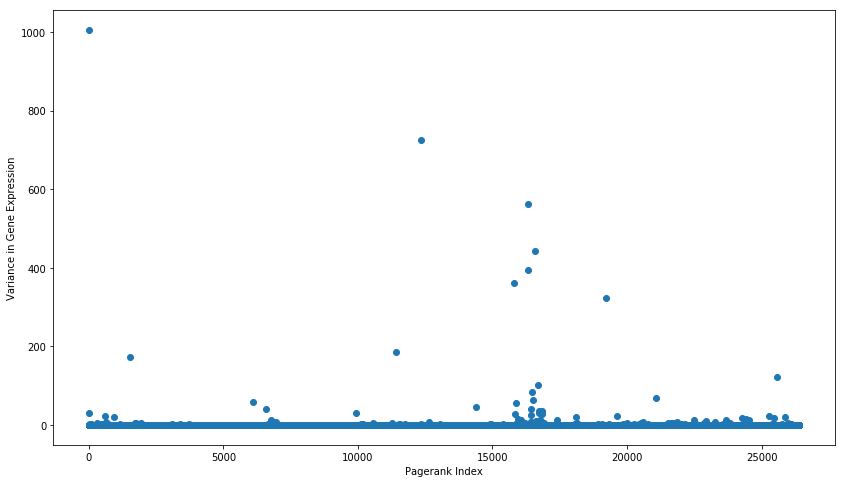

In [50]:
fig = plt.figure(figsize=(14, 8))
ax = plt.scatter(pagerank_with_ge_variance.Rank, pagerank_with_ge_variance.Gene_Expression_Variance)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Variance in Gene Expression')

## Correlations between PageRank & Differential Expression
Because of the flaws of using only the variance, let's try having a look at the differentially expressed genes.
This should overcome the issues and maybe reveal some correlation between PageRank and DE.

Unfortunately, we only have GE data for the differentially expressed genes, while for all others, the p-values are $<0.05$

In [58]:
# load DE for GFP+
differential_expression = pd.DataFrame.from_csv('../data/differential_expression/GFPplusT8vsControlT805.tsv',
                                                sep='\t',
                                                index_col=2
                                               )
differential_expression.shape

(1016, 8)

In [125]:
pagerank_with_de = differential_expression.join(pagerank_scores)
pagerank_with_de.shape

(1016, 11)

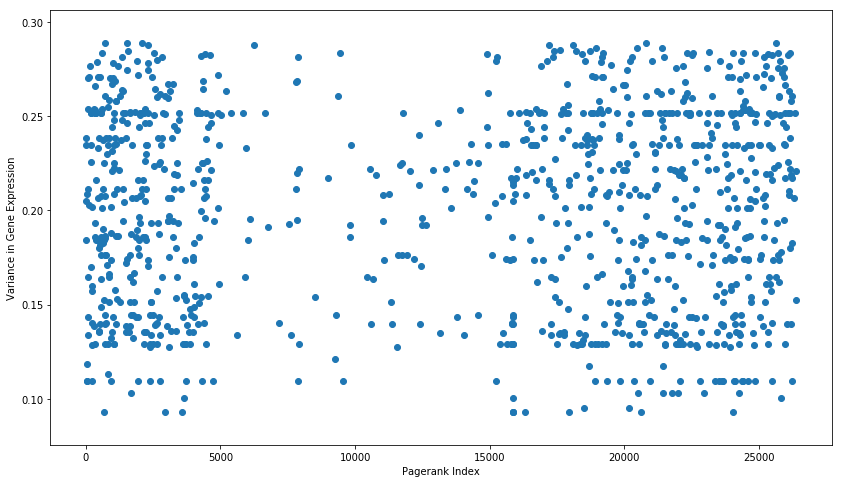

In [74]:
fig = plt.figure(figsize=(14, 8))
ax = plt.scatter(pagerank_with_de.Rank, pagerank_with_de.padj)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Variance in Gene Expression')

## Correlations between PageRank & Gene Expression PCA Loadings

In [143]:
loadings_pc1 = pd.DataFrame.from_csv('../preprocessing/gene_expression/loadings_comp_0.tsv',
                                     sep='\t'
                                    )
loadings_pc1 = loadings_pc1.drop('abs_loadings', axis=1)

loadings_pc2 = pd.DataFrame.from_csv('../preprocessing/gene_expression/loadings_comp_1.tsv',
                                     sep='\t'
                                    )
loadings_pc2 = loadings_pc2.drop('abs_loadings', axis=1)

loadings_pc3 = pd.DataFrame.from_csv('../preprocessing/gene_expression/loadings_comp_2.tsv',
                                     sep='\t'
                                    )
loadings_pc3 = loadings_pc3.drop('abs_loadings', axis=1)

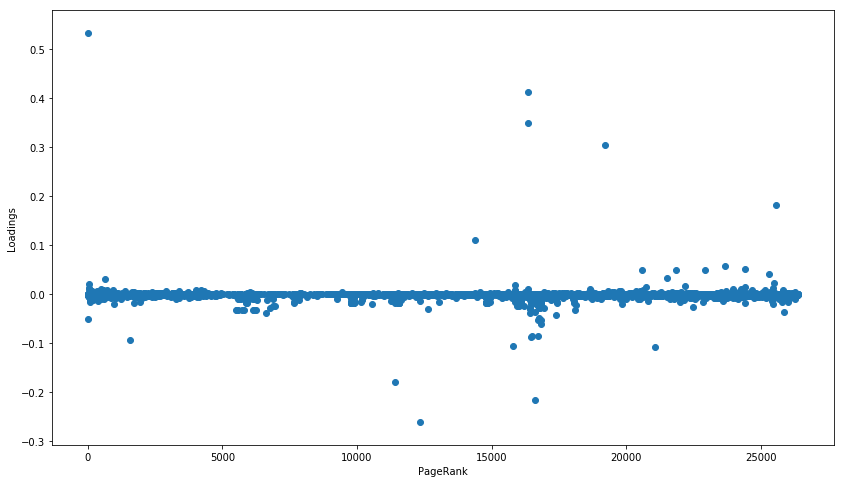

In [144]:
fig = plt.figure(figsize=(14, 8))
pc1_df = loadings_pc1.merge(pagerank_scores, right_on='Gene_Name', left_index=True)
pc1_df.shape
plt.scatter(pc1_df.Rank, pc1_df.loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')

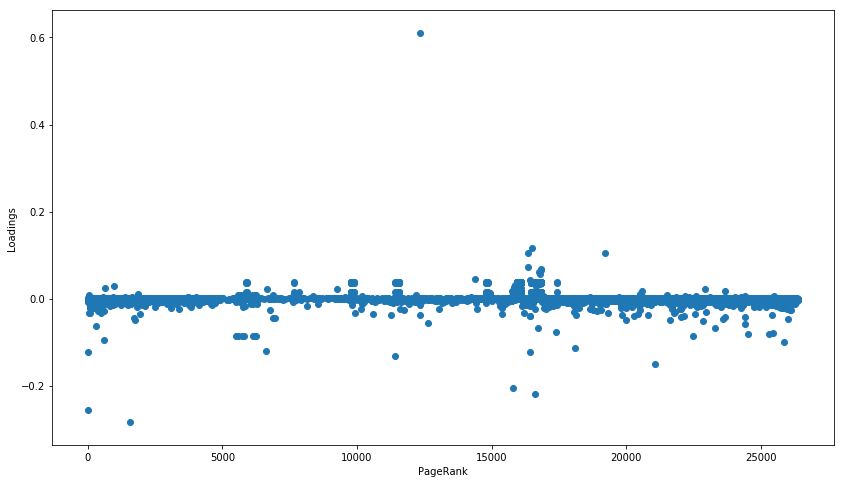

In [146]:
fig = plt.figure(figsize=(14, 8))
pc2_df = loadings_pc2.merge(pagerank_scores, right_on='Gene_Name', left_index=True)
pc2_df.shape
plt.scatter(pc2_df.Rank, pc2_df.loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')

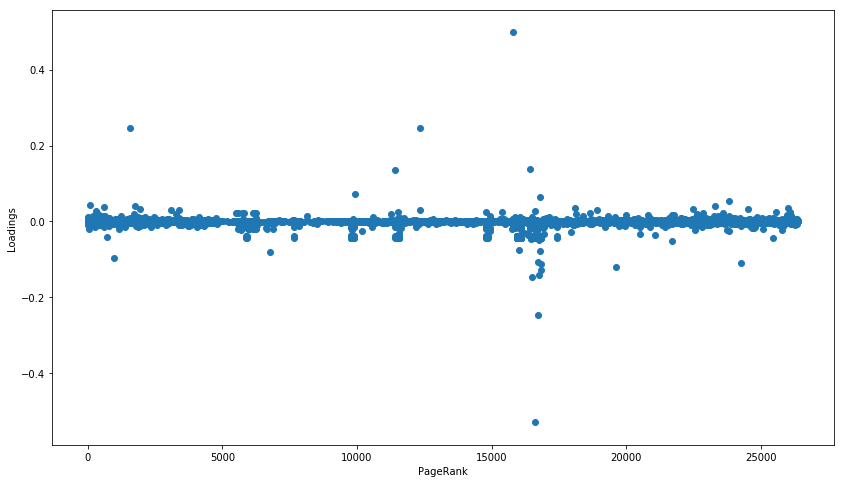

In [147]:
fig = plt.figure(figsize=(14, 8))
pc3_df = loadings_pc3.merge(pagerank_scores, right_on='Gene_Name', left_index=True)
pc3_df.shape
plt.scatter(pc3_df.Rank, pc3_df.loadings)
plt.xlabel('PageRank')
plt.ylabel('Loadings')